## AMAZON FINE FOOD REVIEWS : SUPPORT VECTOR MACHINES

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


**DATA SET SPLITS ** 

1. AVG_WORD2VEC : 70K TRAIN,  30K TEST
2. TFIDF_WORD2VEC : 70K TRAIN ,  30K TEST
3. BOW : 60K TRAIN,  20K CV,  20K TEST
4. TFIDF : 60K TRAIN, 20K CV,  20K TEST

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,roc_auc_score,precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import vstack
import operator
import wordcloud
from scipy.stats import norm, uniform
from sklearn.metrics import roc_curve,auc
from sklearn.decomposition import TruncatedSVD

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [60]:
## importing the data for modelling 
bow_train = pickle.load(open('train_bow.sav','rb'))
bow_cv = pickle.load(open('cv_bow.sav','rb'))
bow_test = pickle.load(open('test_bow.sav','rb'))
y_train = pickle.load(open('y_train.sav','rb'))
y_cv = pickle.load(open('y_cv.sav','rb'))
y_test = pickle.load(open('y_test.sav','rb'))

In [14]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='linear',cache_size=1000,verbose=True)
    svm.fit(bow_train,y_train)
    pred = svm.predict(bow_cv)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]Running for C : 10000

[LibSVM]

**AUC SCORE:** 

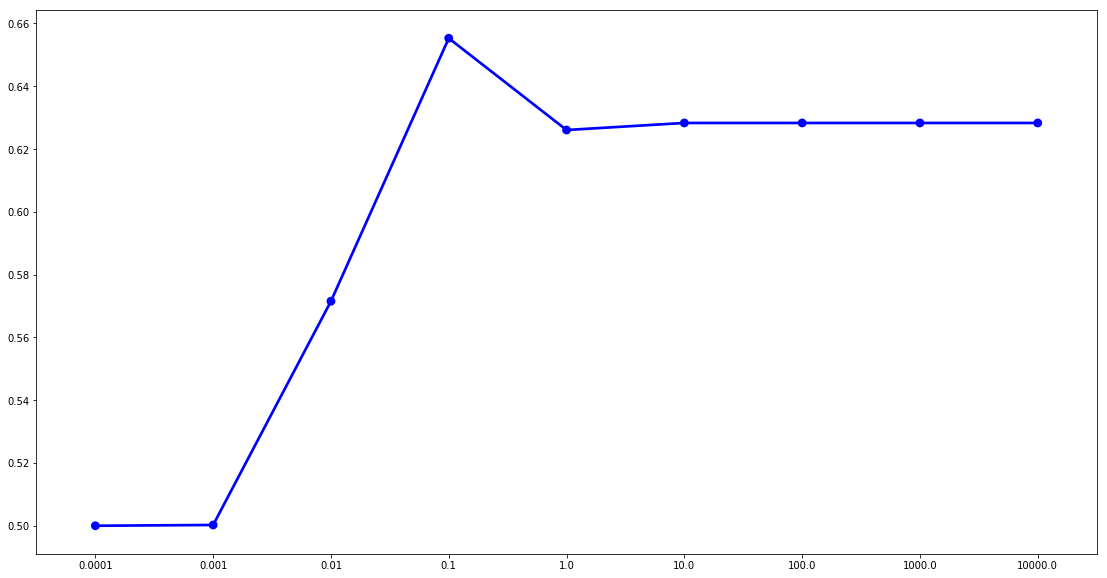

In [15]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : NEGATIVE REVIEWS**

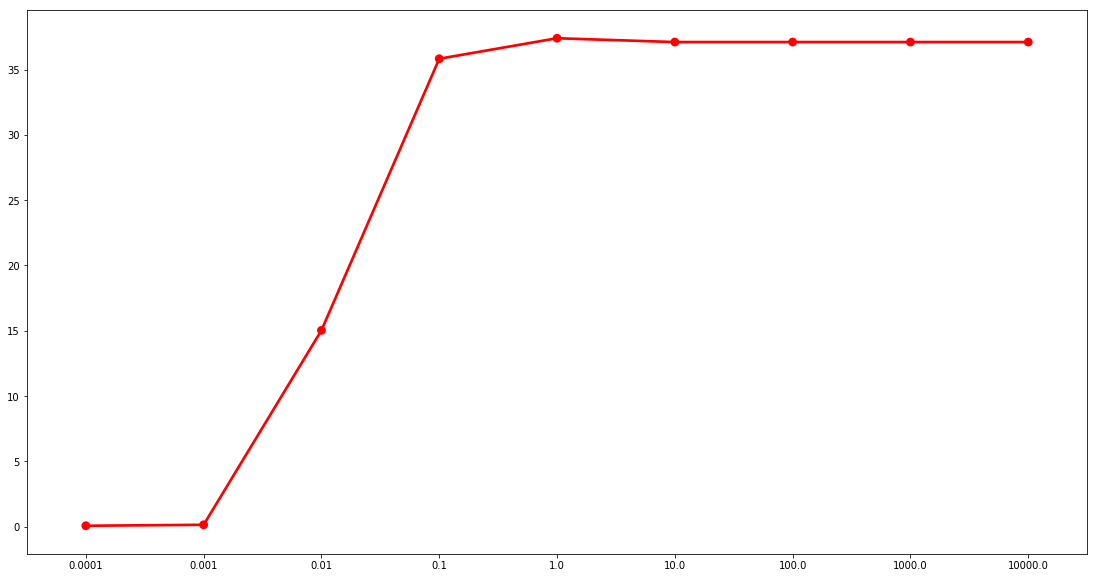

In [21]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION : POSITIVE REVIEWS**

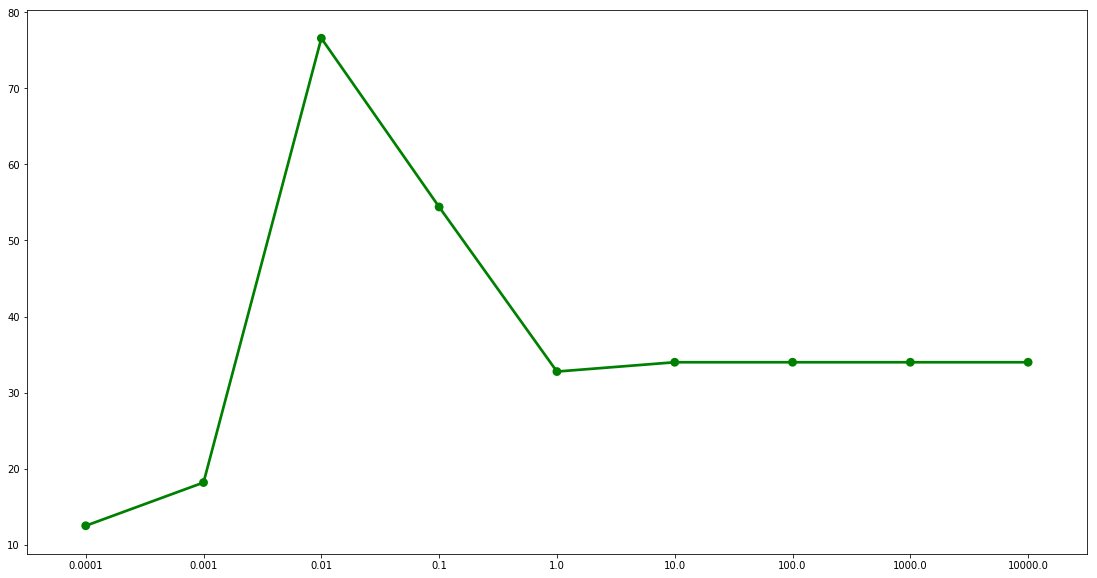

In [22]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

<br>
<br>

1. Even though the precision is very high on C= 0.01, recall and auc seem to very low.
2. We can go with **C = 0.1**


In [61]:
svm = SVC(C=0.1,kernel='linear',cache_size=1000,verbose=True)
svm.fit(bow_train,y_train)
pred = svm.predict(bow_test)
tpred = svm.predict(bow_train)

[LibSVM]

In [4]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.77      0.58      0.66      2674
           1       0.94      0.97      0.96     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.86      0.78      0.81     20000
weighted avg       0.92      0.92      0.92     20000



In [6]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = y_train,y_pred=tpred))))
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TRAIN ERROR : 0.04479999999999995
TEST ERROR : 0.07899999999999996


**ROC-CURVE**

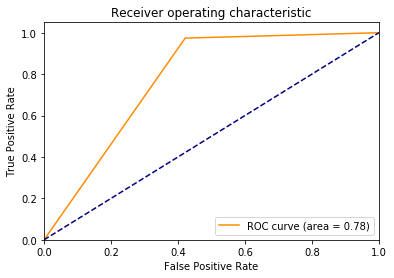

In [64]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRIX:TEST**

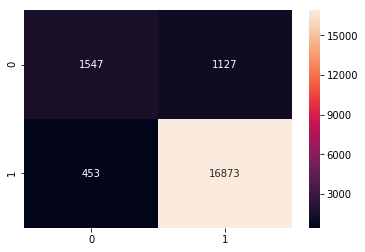

In [7]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

**CONFUSION MATRIX:TRAIN**

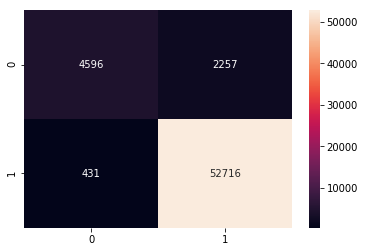

In [8]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

<Br>
<Br>
    
**FEATURE IMPORTANCE:**

In [43]:
val = svm.coef_
f_importance = list(val.toarray().reshape(val.shape[1],))
bow = pickle.load(open('BOW.sav','rb'))
features = bow.get_feature_names()
f_imp = dict(zip(features,f_importance))

In [46]:
p_words = {}
n_words = {}
for i in f_imp:
    if f_imp[i]>0:
        p_words[i] = f_imp[i]
    elif f_imp[i] < 0 :
        n_words[i] = f_imp[i]
    else: 
        pass

<br>
<br>

**POSITIVE WORDS**

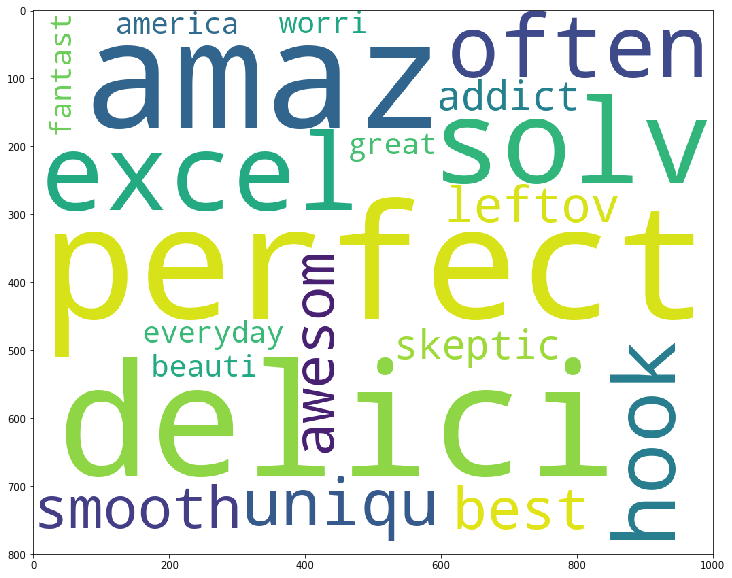

In [50]:
top_20 = {}
for i in sorted(p_words.items(), key=operator.itemgetter(1),reverse= True)[:20]:
      top_20[i[0]] = i[1]

plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

<br>
<Br>
    
**NEGATIVE WORDS:**

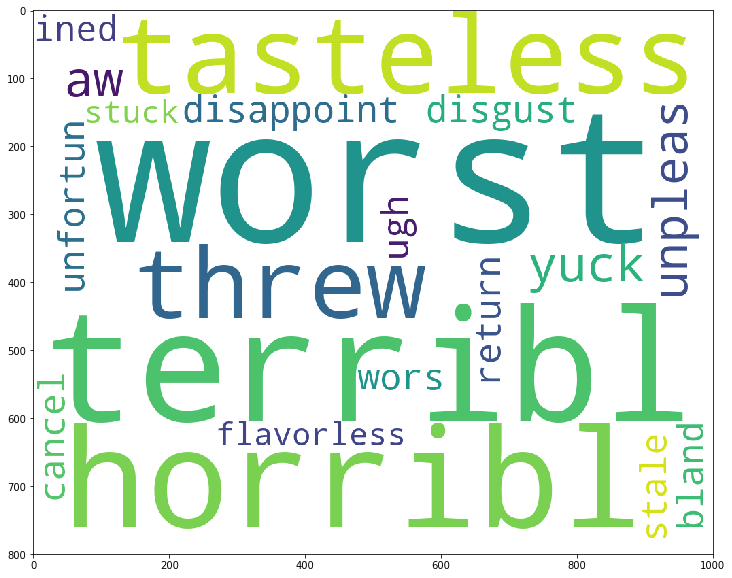

In [53]:
top_20 = {}
for i in sorted(n_words.items(), key=operator.itemgetter(1),reverse= False)[:20]:
      top_20[i[0]] = -1 * i[1]
        
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [57]:
#importing all the data for modelling
tf_train = pickle.load(open('train_tfidf.sav','rb'))
tf_cv = pickle.load(open('cv_tfidf.sav','rb'))
tf_test = pickle.load(open('test_tfidf.sav','rb'))
y_train = pickle.load(open('y_train.sav','rb'))
y_cv = pickle.load(open('y_cv.sav','rb'))
y_test = pickle.load(open('y_test.sav','rb'))

In [55]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='linear',cache_size=1000,verbose=True,max_iter=5000)
    svm.fit(tf_train,y_train)
    pred = svm.predict(tf_cv)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]Running for C : 10000

[LibSVM]

**AUC SCORE:** 

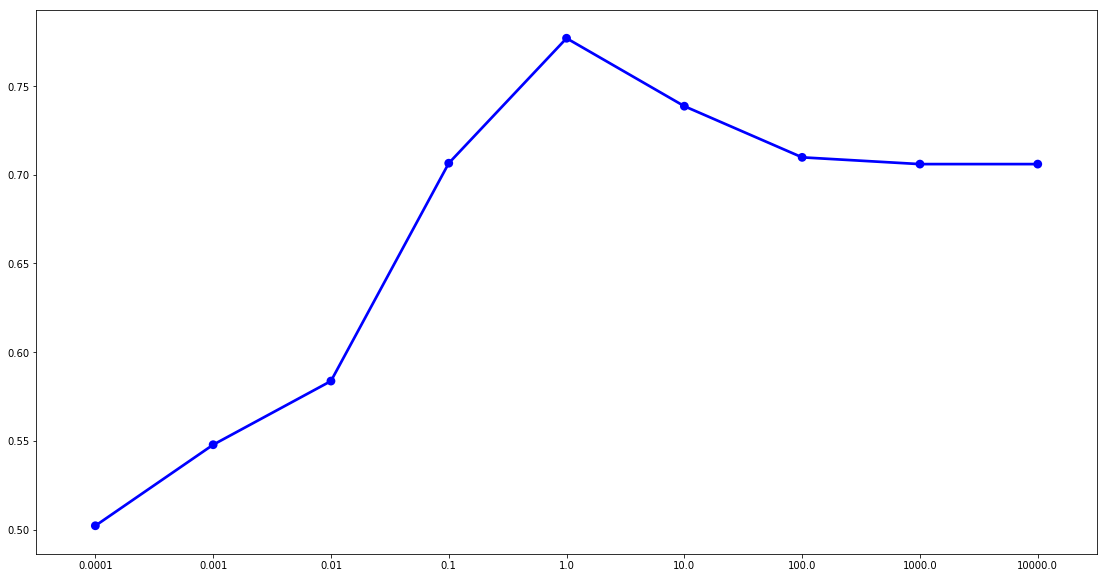

In [58]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL: NEGATIVE REVIEWS**

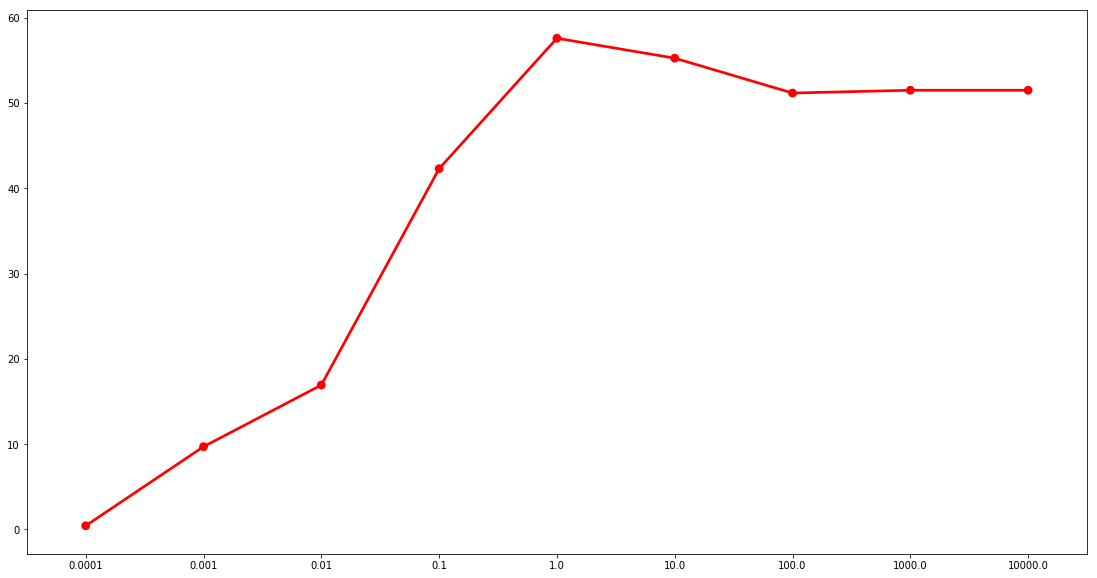

In [57]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION: NEGATIVE REVIEWS**

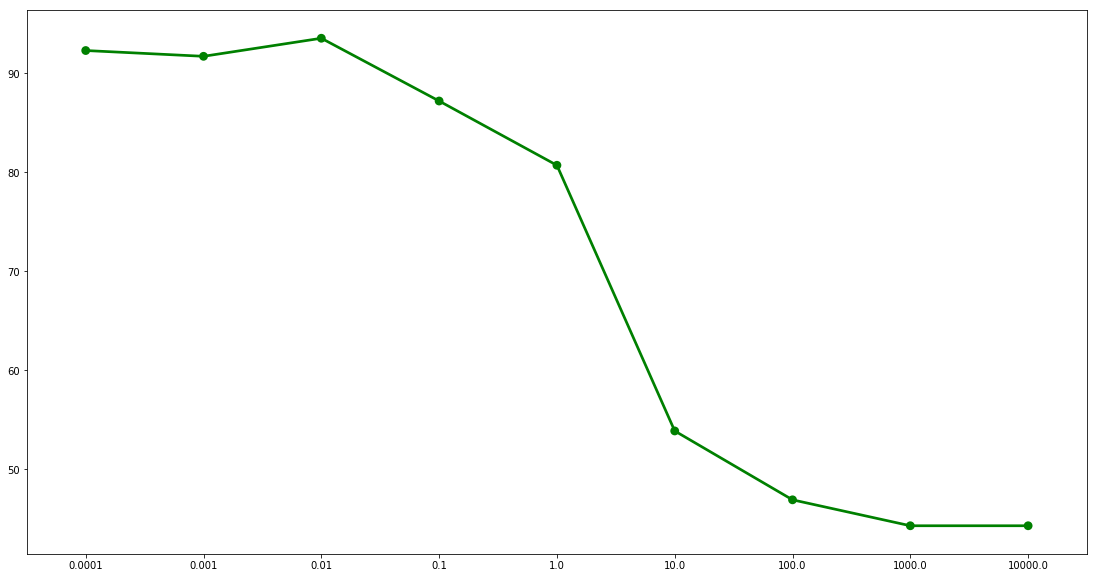

In [59]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

<br>
<br>

AUC and RECALL(NEGATIVE REVIEWS) ARE VERY HIGH FOR C= 1.0 <br>
**C = 1.0** 

In [58]:
svm = SVC(C=1.0,kernel='linear',cache_size=1000,verbose=True)
svm.fit(tf_train,y_train)
pred = svm.predict(tf_test)
tpred = svm.predict(tf_train)

[LibSVM]

In [61]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      2674
           1       0.94      0.98      0.96     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.87      0.77      0.81     20000
weighted avg       0.92      0.92      0.92     20000



In [62]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = y_train,y_pred=tpred))))
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TRAIN ERROR : 0.0470666666666667
TEST ERROR : 0.0756


**ROC-CURVE:**

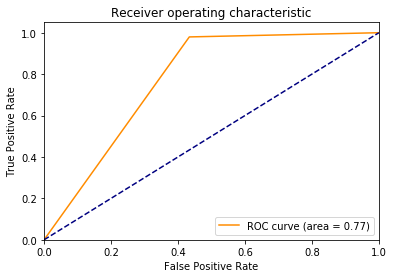

In [59]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


**CONFUSION MATRIX : TEST**

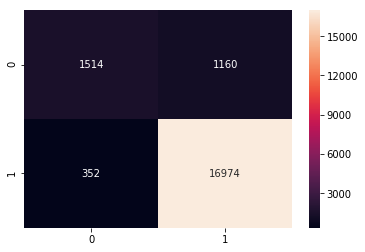

In [63]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

**CONFUSION MATRIX : TRAIN**

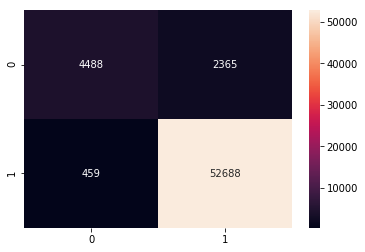

In [64]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

<br>
<Br>

**FEATURE IMPORTANCE:**

In [65]:
val = svm.coef_
f_importance = list(val.toarray().reshape(val.shape[1],))
tf = pickle.load(open('tfidf.sav','rb'))
features = bow.get_feature_names()
f_imp = dict(zip(features,f_importance))

In [66]:
p_words = {}
n_words = {}
for i in f_imp:
    if f_imp[i]>0:
        p_words[i] = f_imp[i]
    elif f_imp[i] < 0 :
        n_words[i] = f_imp[i]
    else: 
        pass

<Br>
<Br>
    
**POSITIVE REVIEWS: TOP FEATURES**

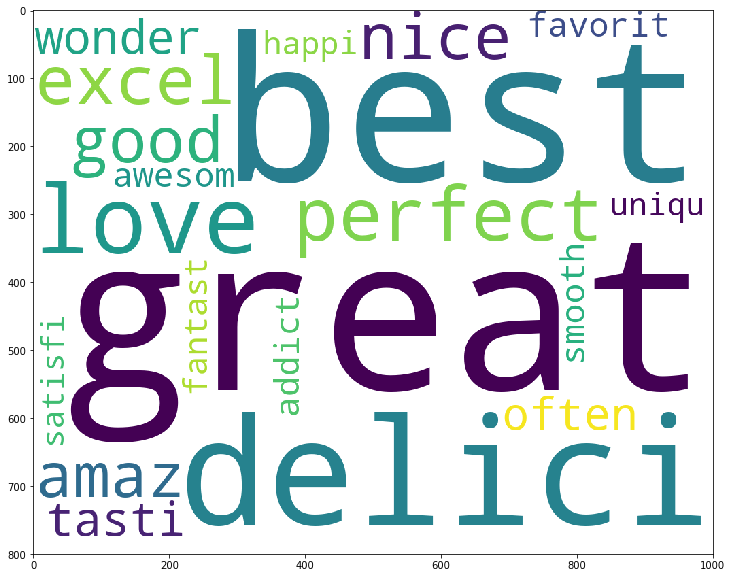

In [67]:
top_20 = {}
for i in sorted(p_words.items(), key=operator.itemgetter(1),reverse= True)[:20]:
      top_20[i[0]] = i[1]

plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

<br>
<br>

**NEGATIVE REVIEWS : TOP FEATURES**

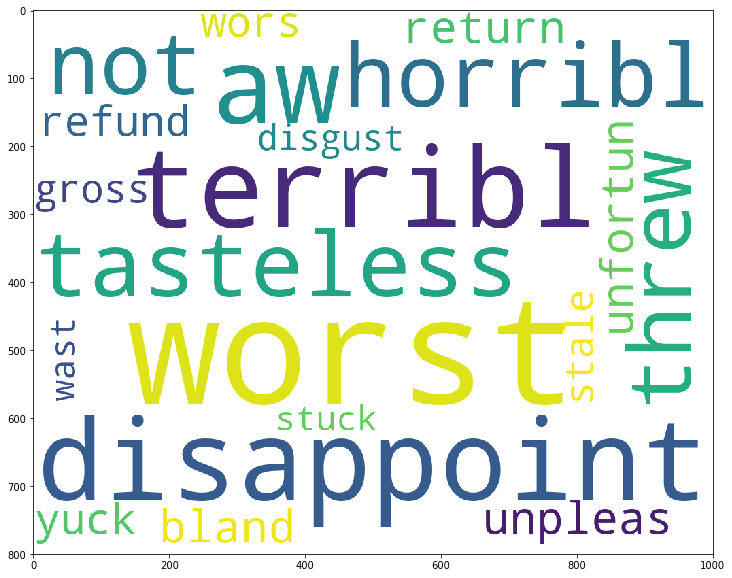

In [68]:
top_20 = {}
for i in sorted(n_words.items(), key=operator.itemgetter(1),reverse= False)[:20]:
      top_20[i[0]] = -1 * i[1]
        
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [150]:
#importing the data for modelling 
w2v_test = pickle.load(open("avg_word2vec_test.sav",'rb'))
w2v_train = pickle.load(open("avg_word2vec_train.sav",'rb'))

In [151]:
#splitting the train into cv and Train 
X_train = w2v_train.iloc[:,0:51]
X_test = w2v_test.iloc[:,0:51]
X_cv = pd.concat([X_train[60000:] , X_test[:10000]],ignore_index=True)
X_train = X_train[:60000].copy(deep=True)
X_test = X_test[10000:]
y_train = X_train['Score']
y_cv = X_cv['Score']
y_test = X_test['Score']
X_train = X_train.iloc[:,0:50].copy(deep=True)
X_test = X_test.iloc[:,0:50].copy(deep=True)
X_cv = X_cv.iloc[:,0:50].copy(deep=True)

In [5]:
X_train.shape

(60000, 50)

In [6]:
X_test.shape

(20000, 50)

In [7]:
X_cv.shape

(20000, 50)

In [152]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='linear',cache_size=1000,verbose=True,max_iter = 10000)
    svm.fit(X_train,y_train)
    pred = svm.predict(X_cv)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]Running for C : 10000

[LibSVM]

**AUC_SCORE**

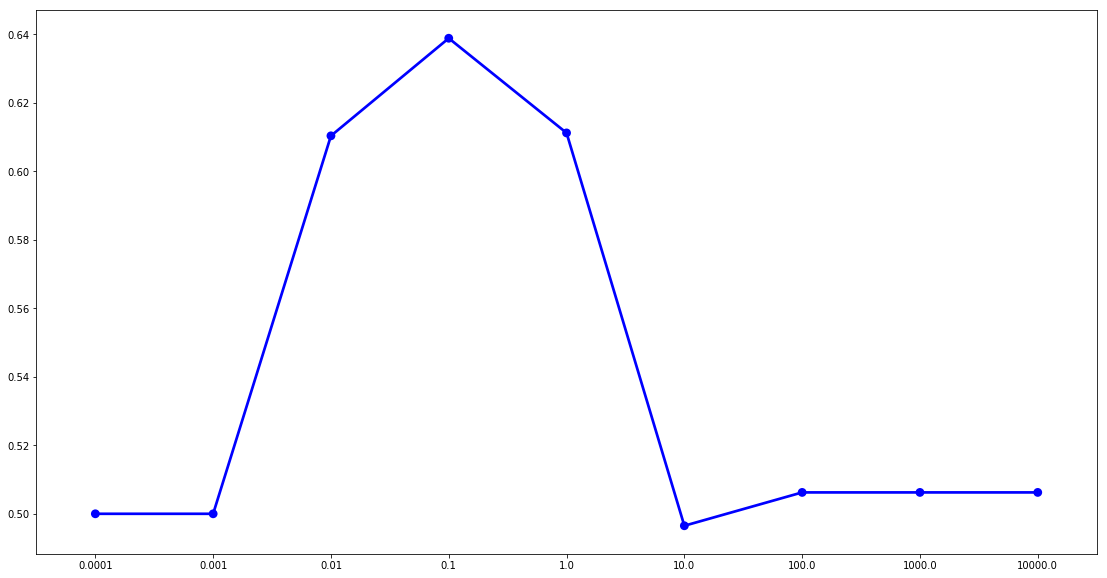

In [153]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : NEGATIVE REVIEWS**

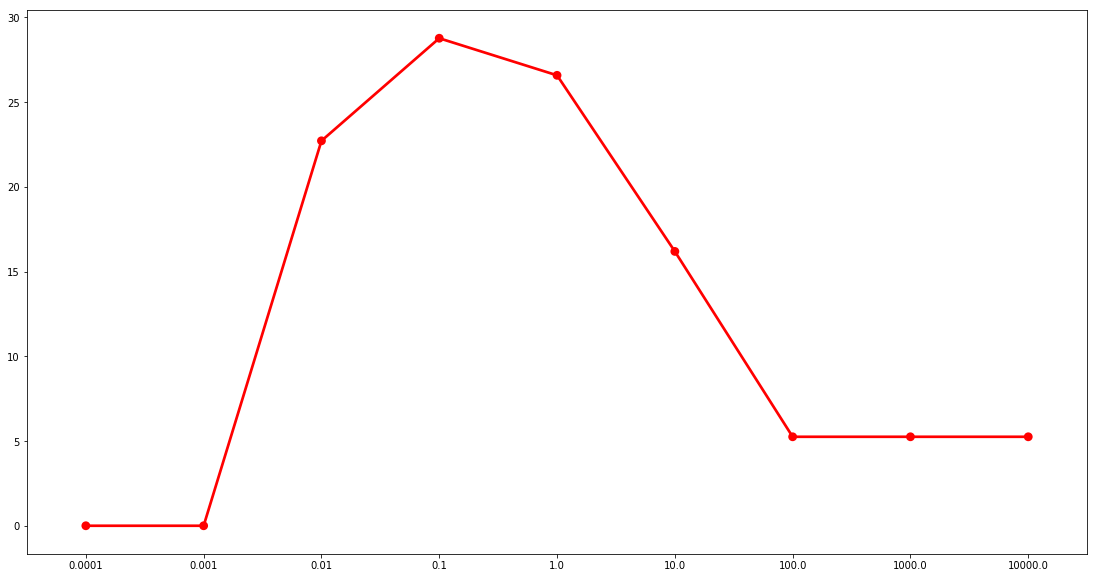

In [154]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

<br>

**PRECISION : NEGATIVE REVIEWS**

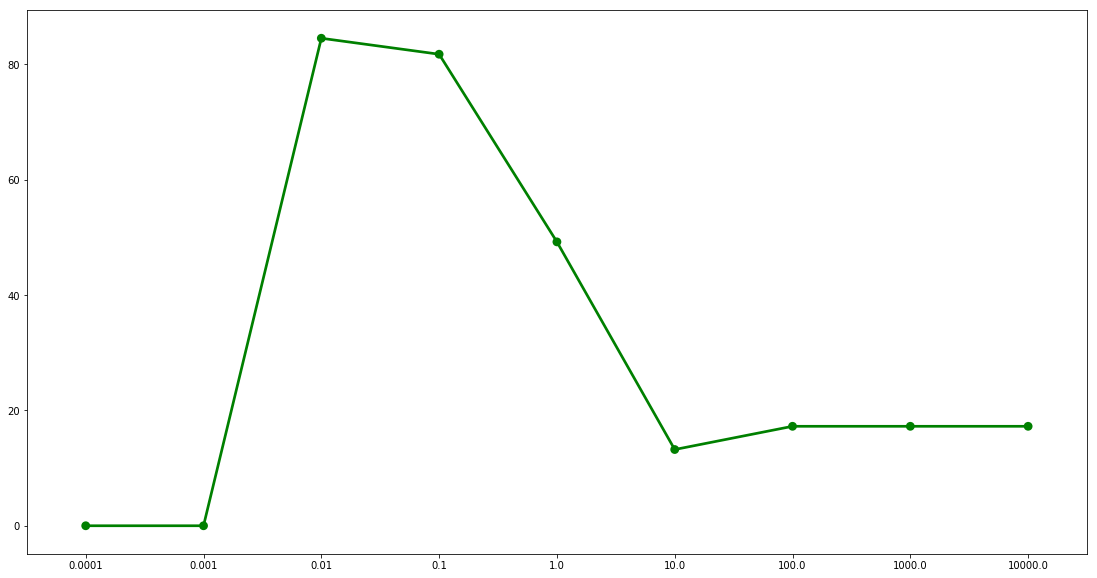

In [155]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')


AUC AND RECALL ARE HIGH AT **C=0.1**

In [54]:
svm = SVC(C=0.1,kernel='linear',cache_size=1000,verbose=True)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)

[LibSVM]

In [55]:
tpred = svm.predict(X_train)

In [15]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.77      0.27      0.40      2674
           1       0.90      0.99      0.94     17326

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.83      0.63      0.67     20000
weighted avg       0.88      0.89      0.87     20000



In [19]:
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))

TRAIN ERROR : 9.284999999999997
TEST ERROR : 10.829999999999998


**ROC-CURVE:**

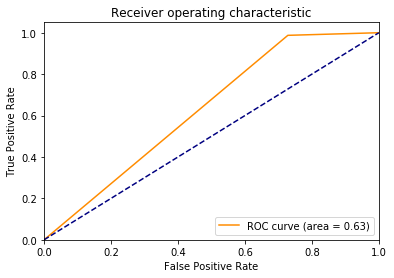

In [56]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


**CONFUSION MATRIX : TEST**

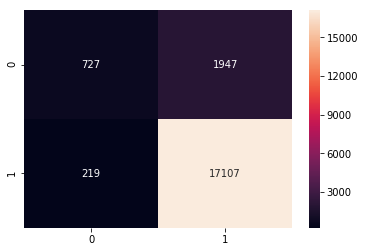

In [17]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')


**CONFUSION MATRIX : TRAIN**

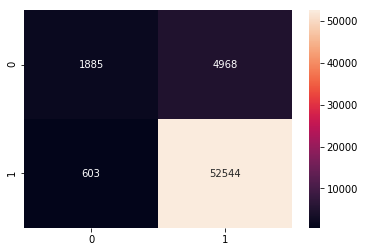

In [18]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [145]:
#importing the data for modelling 
tfw2v_train = pickle.load(open("Train_TFW2V.sav",'rb'))
tfw2v_test = pickle.load(open("Test_TFW2V.sav",'rb'))

#splitting the train into cv and Train 
X_train = tfw2v_train.iloc[:,0:51]
X_test = tfw2v_test.iloc[:,0:51]
X_cv = pd.concat([X_train[60000:] , X_test[:10000]],ignore_index=True)
X_train = X_train[:60000].copy(deep=True)
X_test = X_test[10000:]
y_train = X_train['Score']
y_cv = X_cv['Score']
y_test = X_test['Score']
X_train = X_train.iloc[:,0:50].copy(deep=True)
X_test = X_test.iloc[:,0:50].copy(deep=True)
X_cv = X_cv.iloc[:,0:50].copy(deep=True)

In [25]:
X_train.shape

(60000, 50)

In [26]:
X_test.shape

(20000, 50)

In [27]:
X_cv.shape

(20000, 50)

In [146]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='linear',cache_size=1000,verbose=True,max_iter = 10000)
    svm.fit(X_train,y_train)
    pred = svm.predict(X_cv)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]Running for C : 10000

[LibSVM]

**AUC SCORE**

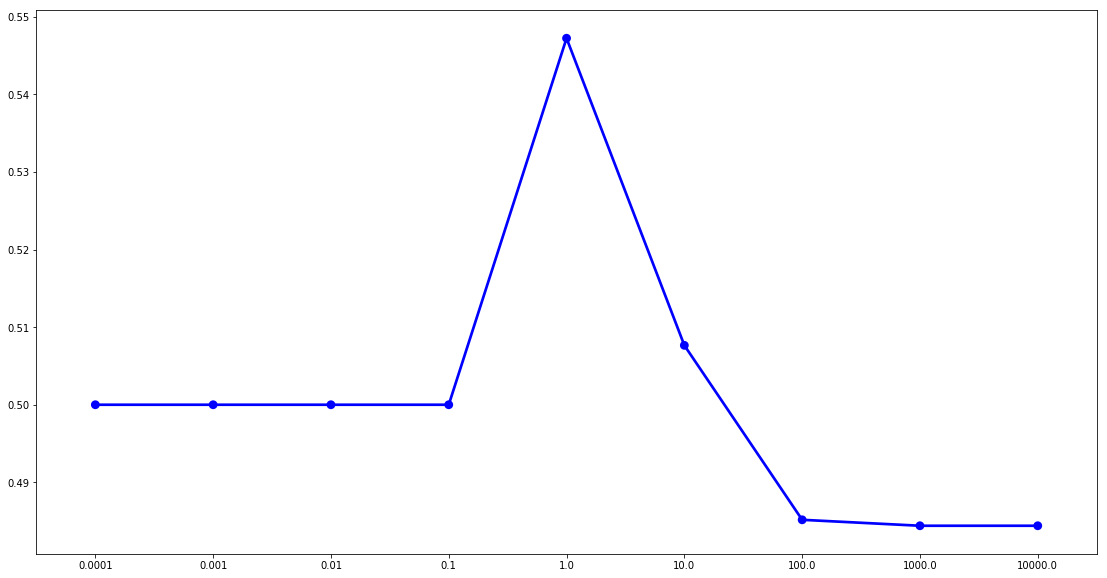

In [147]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

<br>

**RECALL : NEGATIVE REVIEWS**

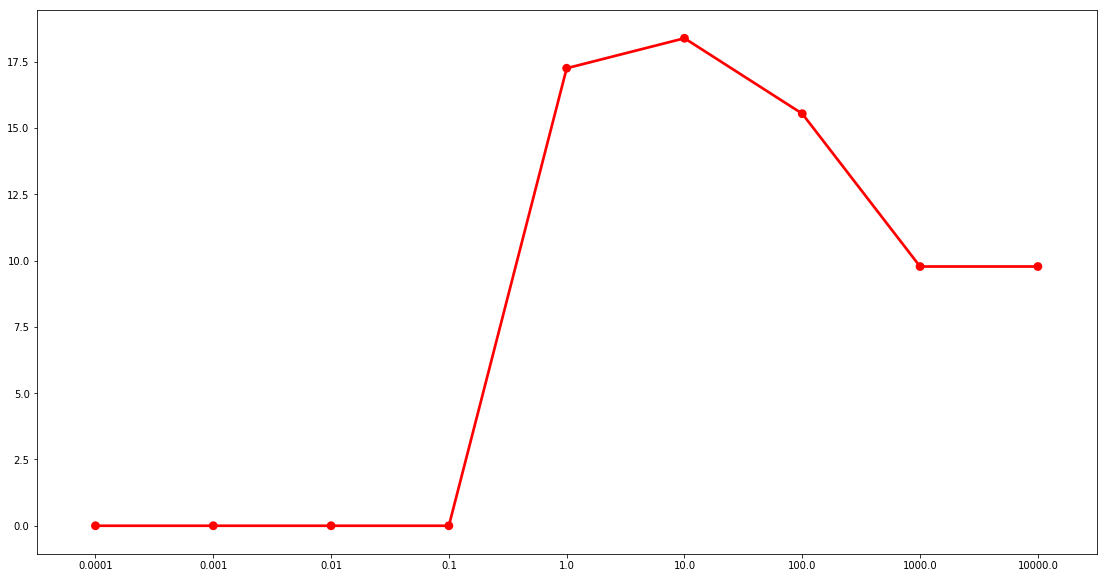

In [148]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

<br>

**PRECISION : NEGATIVE REVIEWS**

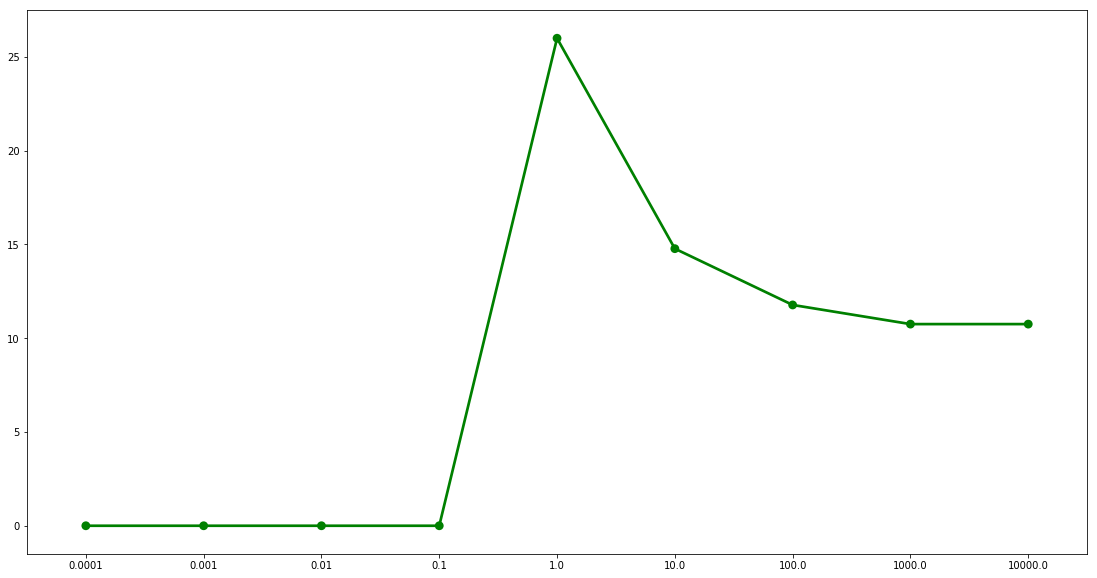

In [149]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

ALL THE METRICS ARE HIGH AT **C=1.0** <br>
BUT THE MAGNITUDE OF THE METRICS ARE VERY LOW FOR THIS REPRESENTATION

In [37]:
svm = SVC(C=1.0,kernel='linear',cache_size=1000,verbose=True,max_iter=10000)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
tpred = svm.predict(X_train)

[LibSVM]

In [38]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.26      0.17      0.21      2674
           1       0.88      0.93      0.90     17326

   micro avg       0.83      0.83      0.83     20000
   macro avg       0.57      0.55      0.55     20000
weighted avg       0.80      0.83      0.81     20000



In [39]:
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))

TRAIN ERROR : 16.83333333333333
TEST ERROR : 17.450000000000003


**ROC-CURVE**

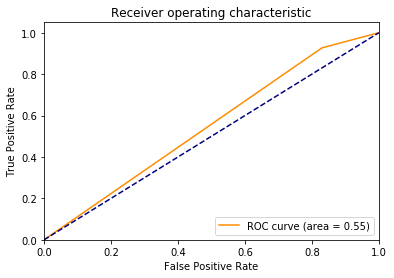

In [49]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRIX : TEST**


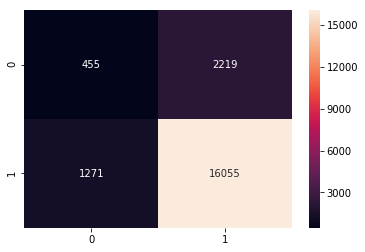

In [40]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

**CONFUSION MATRIX : TRAIN**

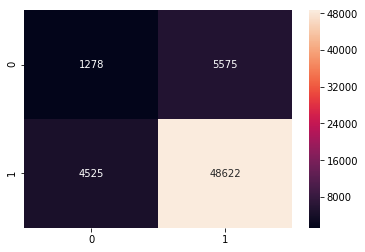

In [41]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [51]:
# importing the data for modelling 
bow_train = pickle.load(open('train_bow.sav','rb'))
y_train = pickle.load(open('y_train.sav','rb'))

Reducing dimensions : 500 with SVD

In [52]:
tvd = TruncatedSVD(n_components=500,n_iter=10)

In [53]:
X_train = tvd.fit_transform(bow_train)

In [54]:
percentage_var_explained = tvd.explained_variance_ / np.sum(tvd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

Text(0, 0.5, 'Explained Variance Ratio')

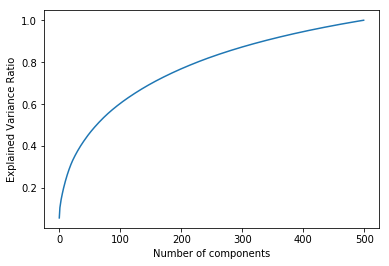

In [55]:
plt.plot(np.arange(0,500),cum_var_explained)
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio")

We are good to go as with 500 dimensions more than 95% of variance is preserved.

In [6]:
#splitting the dataset into train cv and test

#train = 40k sample
#cv = 10k sample
#test = 10k sample 
bow_train = X_train[:40000]
bow_cv = X_train[40000:50000]
bow_test = X_train[50000:]
y_cv = y_train[40000:50000]
y_test = y_train[50000:]
y_train = y_train[:40000]

In [7]:
#single cross validation 
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
    svm.fit(bow_train,y_train)
    pred = svm.predict(bow_cv)
    tpred =svm.predict(bow_train)
    train_error[i] = 100-((accuracy_score(y_true = y_train,y_pred=tpred))*100)
    test_error[i] = 100-((accuracy_score(y_true = y_cv,y_pred=pred))*100)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]

**AUC SCORE**

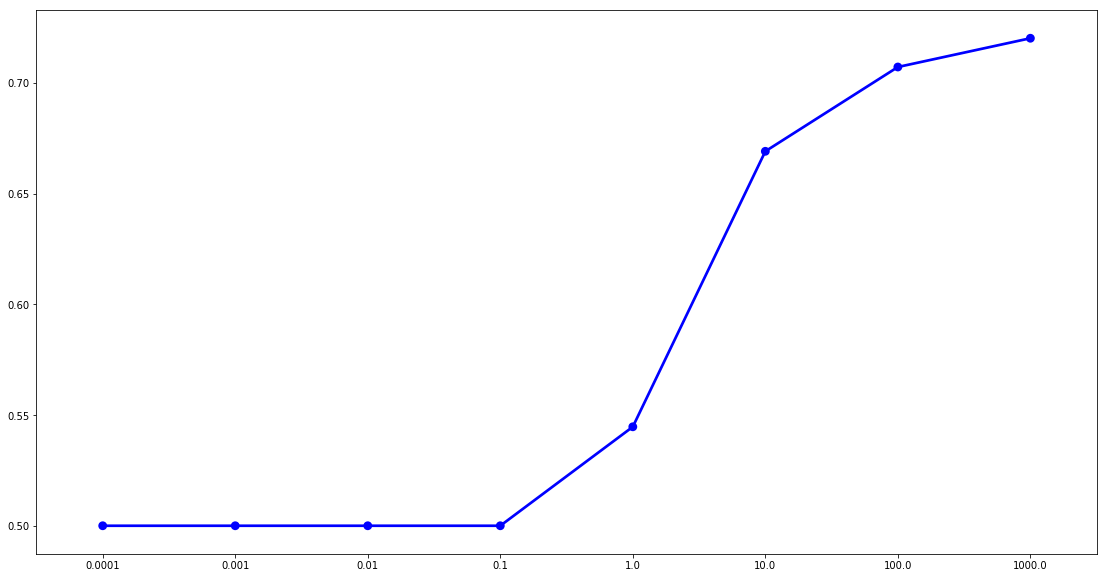

In [8]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : NEGATIVE REVIEWS**

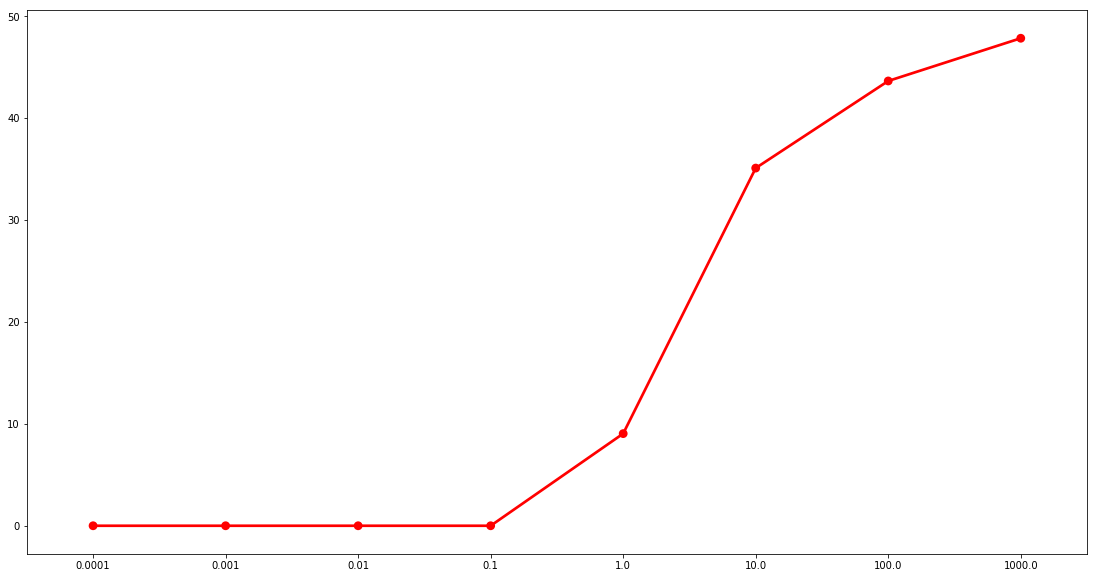

In [9]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION: NEGAVTIVE REVIEWS**

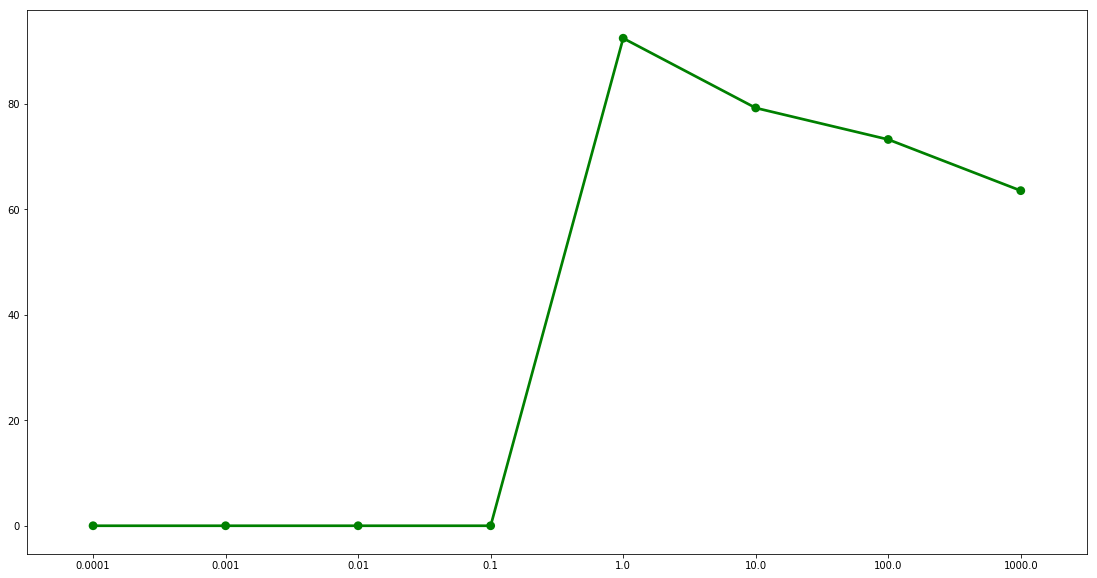

In [11]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

**CV-TRAIN ERROR PLOTS**

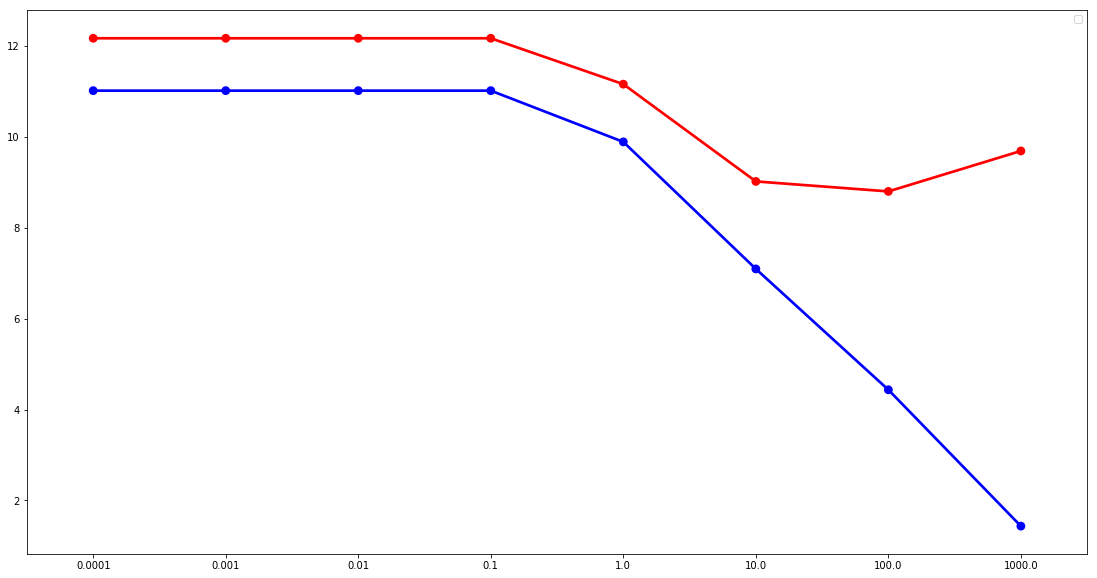

In [12]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),list(train_error.values()),color = 'blue')
sns.pointplot(list(test_error.keys()),list(test_error.values()),color = 'red')
plt.legend(('blue','red'),('Test_error','Train_error'))

**CV-TRAIN DIFFERENCE**

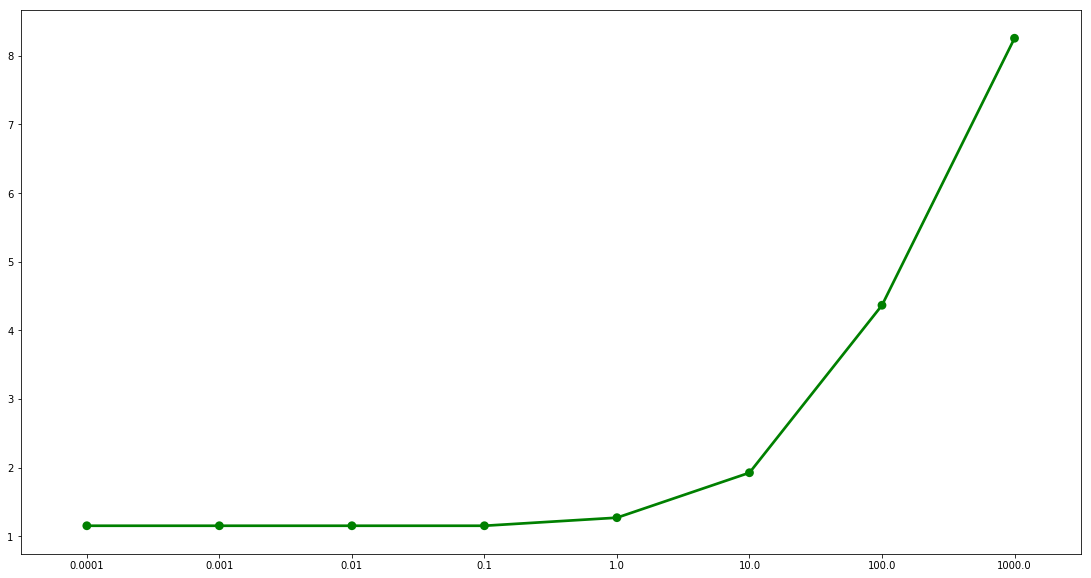

In [13]:
difference = []
for i in test_error:
    difference.append(test_error[i]-train_error[i])
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),difference,color = 'green')

<br>

**C = 10.0**

In [15]:
svm = SVC(C=10,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
svm.fit(bow_train,y_train)
pred = svm.predict(bow_test)
tpred = svm.predict(bow_train)

In [17]:
print(classification_report(y_true = y_test,y_pred=pred))

print("\n\n")
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))

              precision    recall  f1-score   support

           0       0.79      0.34      0.48      1229
           1       0.91      0.99      0.95      8771

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.85      0.66      0.71     10000
weighted avg       0.90      0.91      0.89     10000




TRAIN ERROR : 7.094999999999999
TEST ERROR : 9.209999999999994


**ROC-CURVE**

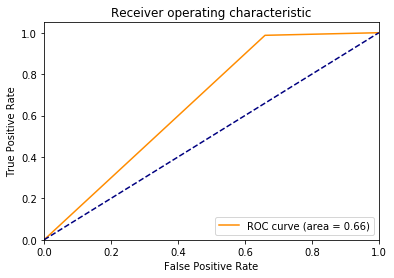

In [19]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRIX : TEST**

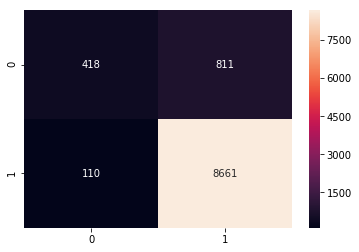

In [20]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')


**CONFUSION MATRIX : TRAIN**

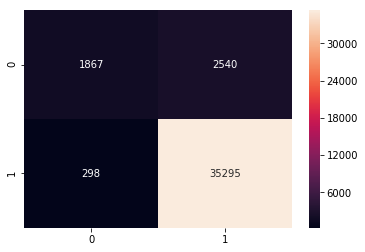

In [21]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [56]:
#importing data for modelling 
tf_train = pickle.load(open('train_tfidf.sav','rb'))
y_train = pickle.load(open('y_train.sav','rb'))

REDUCING THE DIMENSIONS USING TRUNCATED SVD : 500

In [57]:
tvd = TruncatedSVD(n_components=500,n_iter=10)

X_train = tvd.fit_transform(tf_train)

In [58]:
percentage_var_explained = tvd.explained_variance_ / np.sum(tvd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

Text(0, 0.5, 'Explained Variance Ratio')

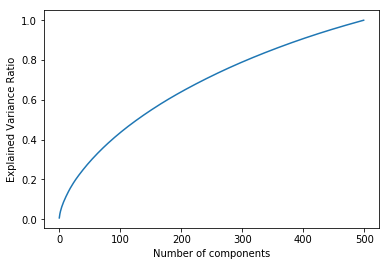

In [59]:
plt.plot(np.arange(0,500),cum_var_explained)
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio")

In [34]:
#500 dimensions are good to go
#splitting the dataset into train cv and test

#train = 40k sample
#cv = 10k sample
#test = 10k sample 
tf_train = X_train[:40000]
tf_cv = X_train[40000:50000]
tf_test = X_train[50000:]
y_cv = y_train[40000:50000]
y_test = y_train[50000:]
y_train = y_train[:40000]

In [36]:
#single cross validation 
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
    svm.fit(tf_train,y_train)
    pred = svm.predict(tf_cv)
    tpred =svm.predict(tf_train)
    train_error[i] = 100-((accuracy_score(y_true = y_train,y_pred=tpred))*100)
    test_error[i] = 100-((accuracy_score(y_true = y_cv,y_pred=pred))*100)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]

**AUC-SCORE**

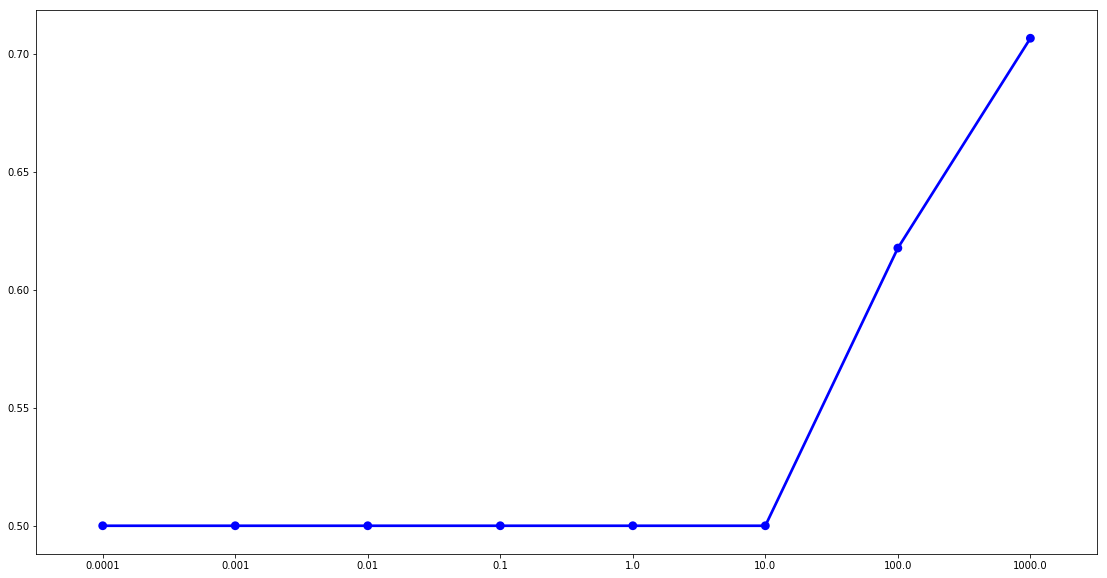

In [37]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : NEGATIVE REVIEWS**

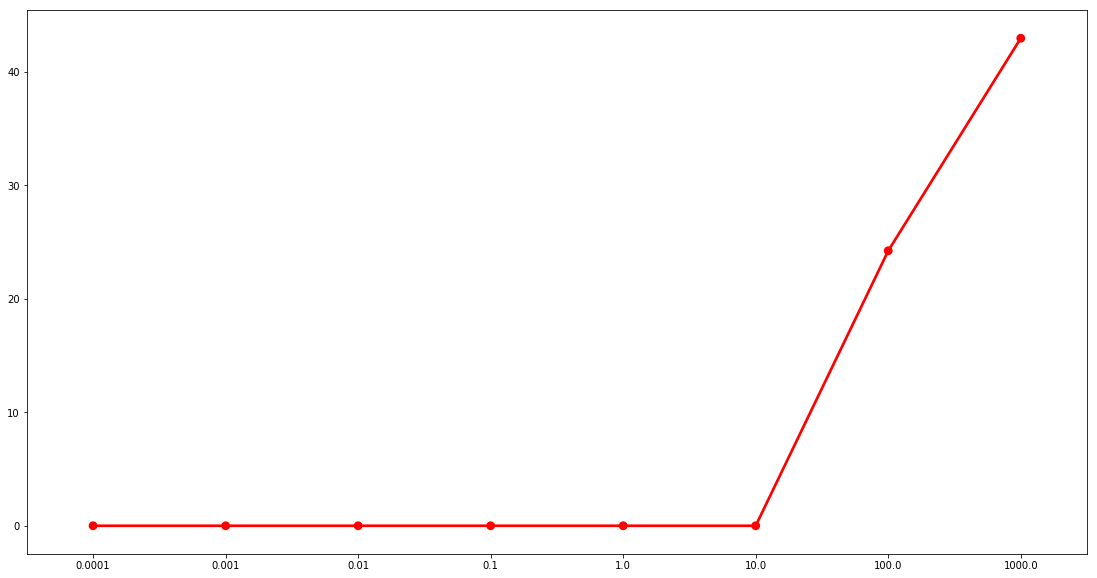

In [38]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION : NEGATIVE REVIEWS**

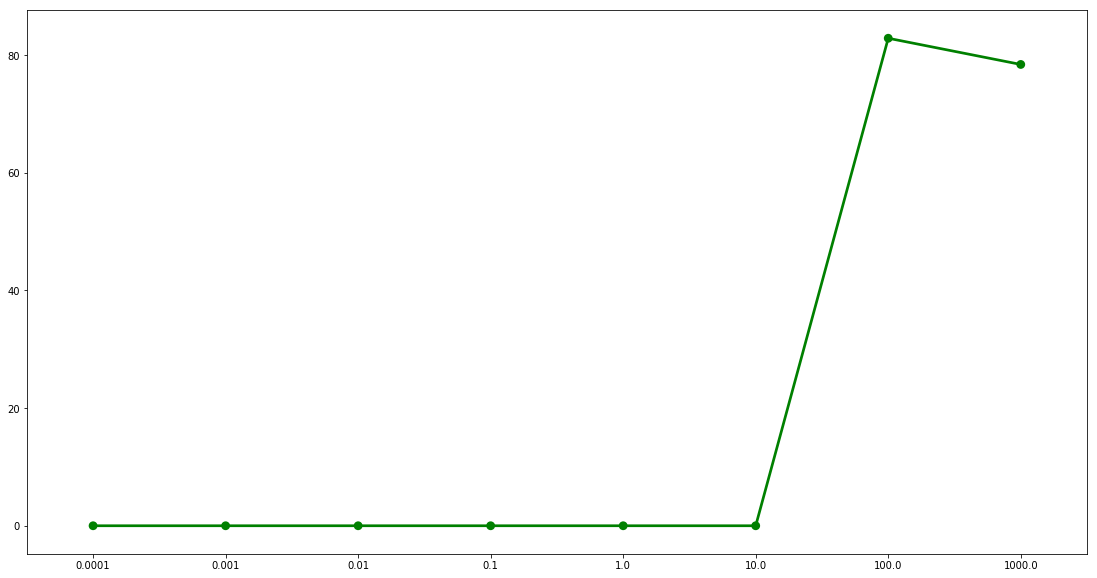

In [39]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

**TRAIN-CV ERROR PLOT AND DIFFERENCE**

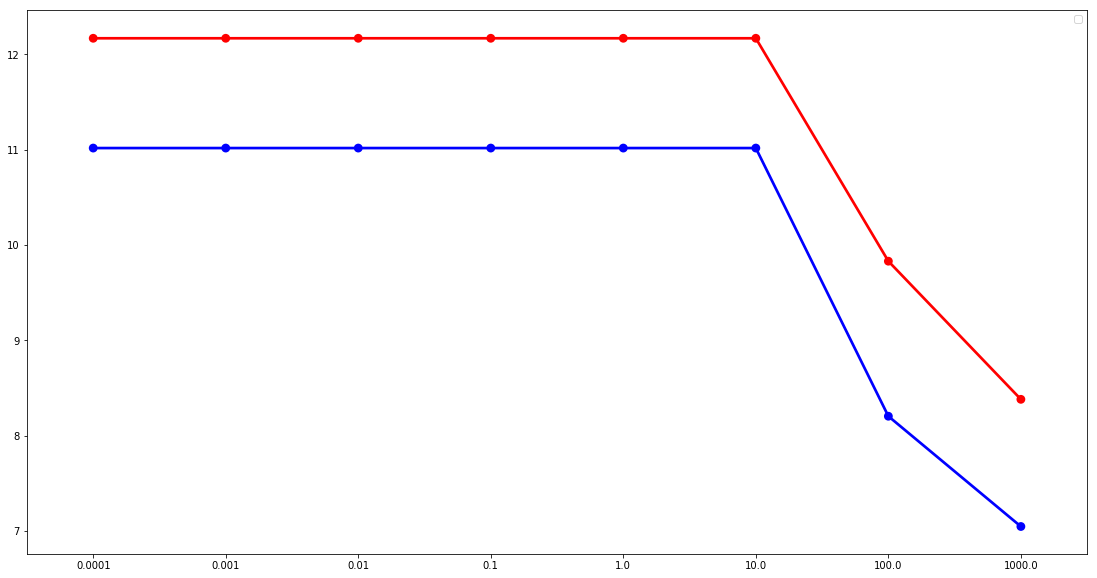

In [40]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),list(train_error.values()),color = 'blue')
sns.pointplot(list(test_error.keys()),list(test_error.values()),color = 'red')
plt.legend(('blue','red'),('Test_error','Train_error'))

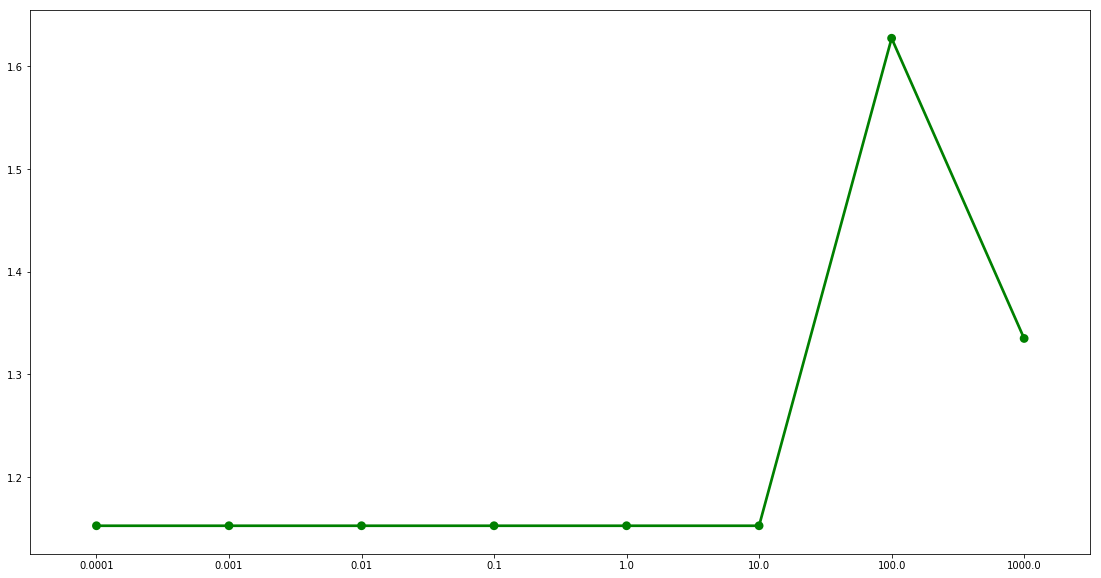

In [41]:
difference = []
for i in test_error:
    difference.append(test_error[i]-train_error[i])
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),difference,color = 'green')

<br>

**C=1000**

In [42]:
svm = SVC(C=1000,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
svm.fit(tf_train,y_train)
pred = svm.predict(tf_test)
tpred =svm.predict(tf_train)

[LibSVM]

In [43]:
print(classification_report(y_true = y_test,y_pred=pred))

print("\n\n")
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))


              precision    recall  f1-score   support

           0       0.78      0.41      0.54      1229
           1       0.92      0.98      0.95      8771

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.85      0.70      0.75     10000
weighted avg       0.91      0.91      0.90     10000




TRAIN ERROR : 7.045000000000002
TEST ERROR : 8.61


**ROC-CURVE**

In [44]:
from sklearn.metrics import auc

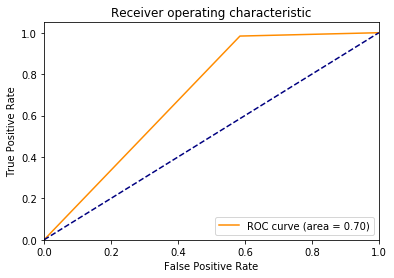

In [45]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRIX : TEST**

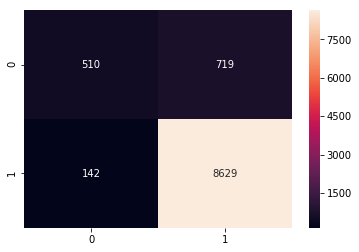

In [46]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

**CONFUSION MATRIX : TRAIN**

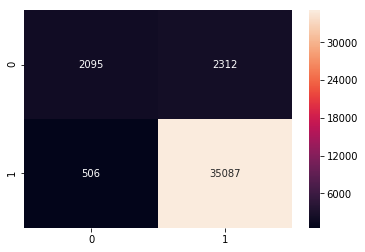

In [47]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [99]:
#importing the data for modelling 
w2v_test = pickle.load(open("avg_word2vec_test.sav",'rb'))
w2v_train = pickle.load(open("avg_word2vec_train.sav",'rb'))

#splitting the train into cv and Train 
#train : 40 k Sample 
#cv : 15k Sample
#test : 15k Sample 
X_train = w2v_train.iloc[:,0:51]
X_test = w2v_test.iloc[:,0:51]
X_cv = X_train[40000:55000]
X_test = X_train[55000:]
X_train = X_train[:40000].copy(deep=True)
y_train = X_train['Score'][:40000].copy(deep=True)
y_cv = X_cv['Score']
y_test = X_test['Score']
X_train = X_train.iloc[:,0:50].copy(deep=True)
X_test = X_test.iloc[:,0:50].copy(deep=True)
X_cv = X_cv.iloc[:,0:50].copy(deep=True)

In [100]:
X_train.shape

(40000, 50)

In [101]:
X_cv.shape

(15000, 50)

In [102]:
X_test.shape

(15000, 50)

In [103]:
pd.value_counts(y_train)

1    35593
0     4407
Name: Score, dtype: int64

In [104]:
pd.value_counts(y_cv)

1    13153
0     1847
Name: Score, dtype: int64

In [105]:
pd.value_counts(y_test)

1    13086
0     1914
Name: Score, dtype: int64

In [125]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
    svm.fit(X_train,y_train)
    pred = svm.predict(X_cv)
    tpred =svm.predict(X_train)
    train_error[i] = 100-((accuracy_score(y_true = y_train,y_pred=tpred))*100)
    test_error[i] = 100-((accuracy_score(y_true = y_cv,y_pred=pred))*100)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]

**AUC-SCORE**

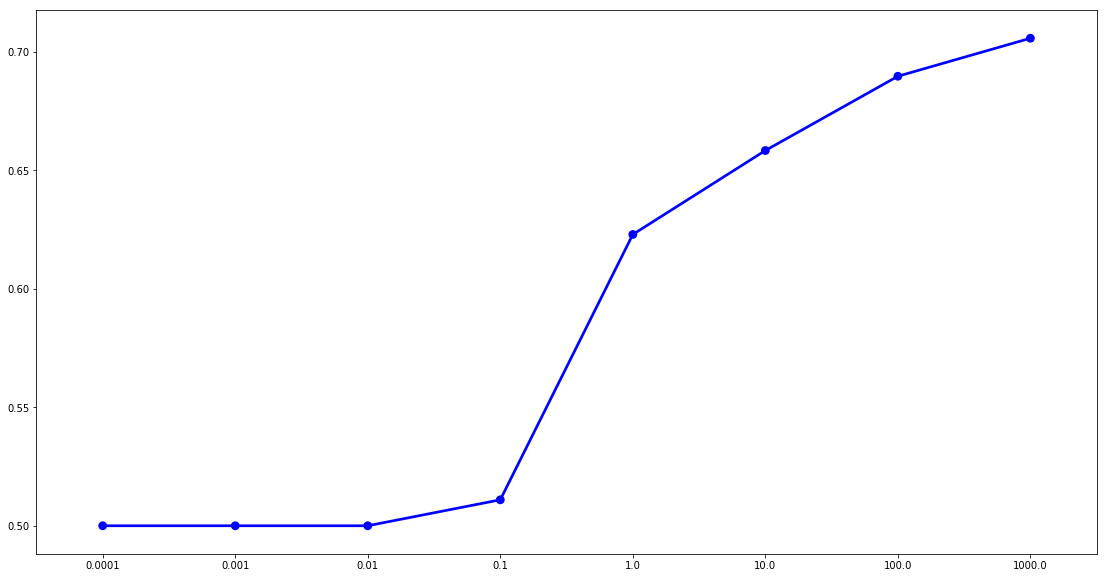

In [126]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : NEGATIVE REVIEWS**

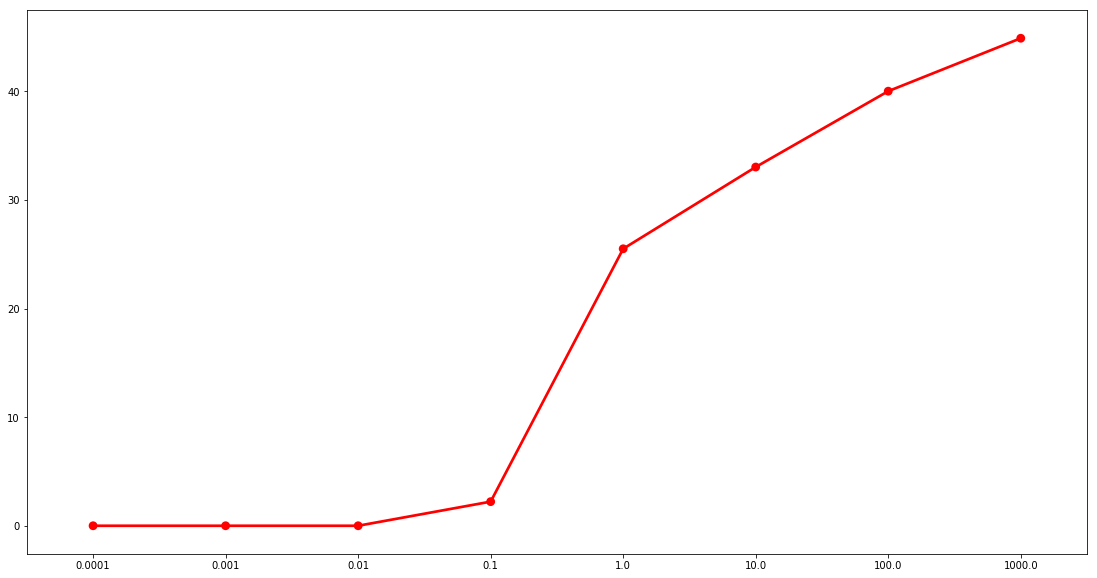

In [127]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION : NEGATIVE REVIEWS**

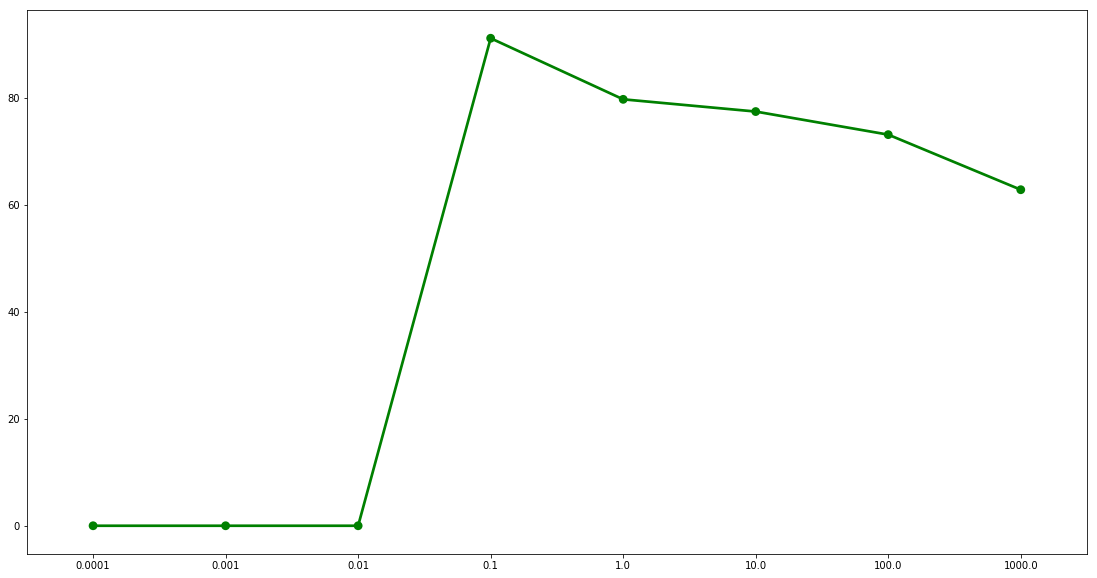

In [124]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

<Br>
    
**TRAIN AND TEST ERROR PLOTS**

In [132]:
difference = []
for i in test_error:
    difference.append(test_error[i]-train_error[i])

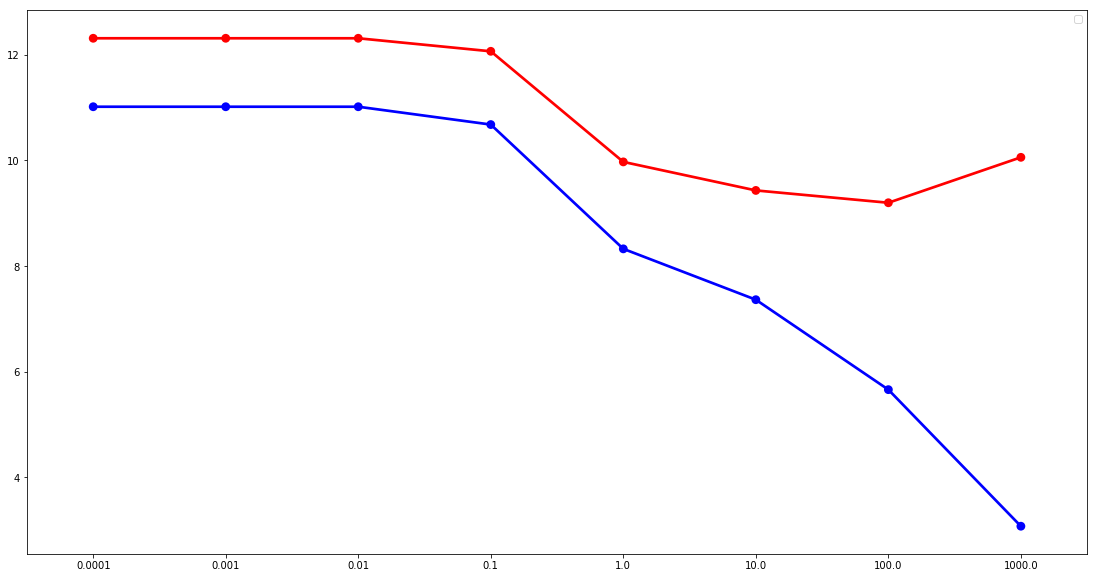

In [128]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),list(train_error.values()),color = 'blue')
sns.pointplot(list(test_error.keys()),list(test_error.values()),color = 'red')
plt.legend(('blue','red'),('Test_error','Train_error'))

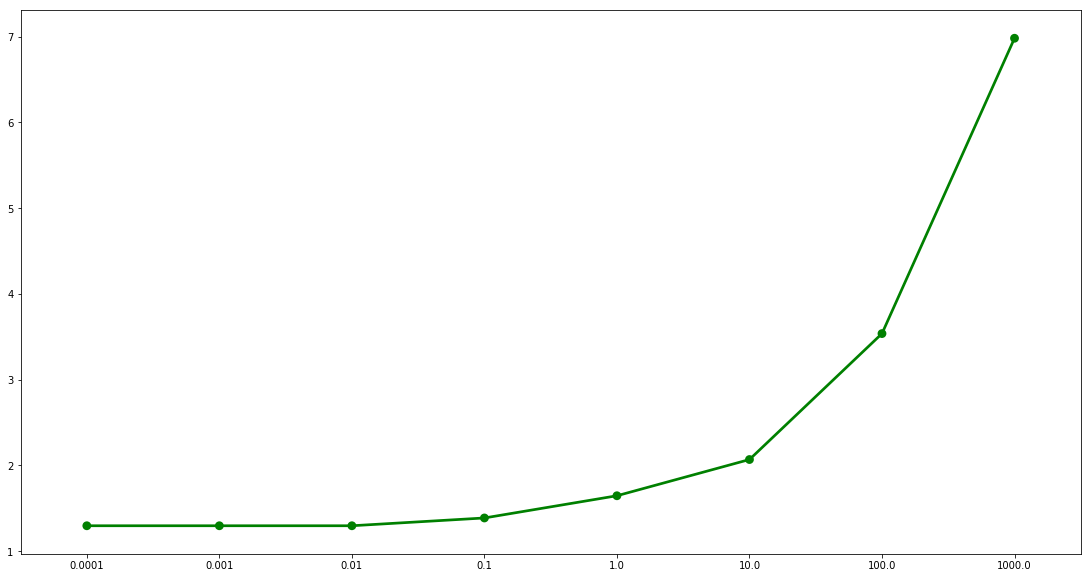

In [133]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),difference,color = 'green')

<br>

**C=1.0**

In [134]:
svm = SVC(C=1.0,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)

[LibSVM]

In [135]:
tpred = svm.predict(X_train)

In [136]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.79      0.30      0.43      1914
           1       0.91      0.99      0.95     13086

   micro avg       0.90      0.90      0.90     15000
   macro avg       0.85      0.64      0.69     15000
weighted avg       0.89      0.90      0.88     15000



In [137]:
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))

TRAIN ERROR : 8.3275
TEST ERROR : 9.993333333333325


**ROC-CURVE**

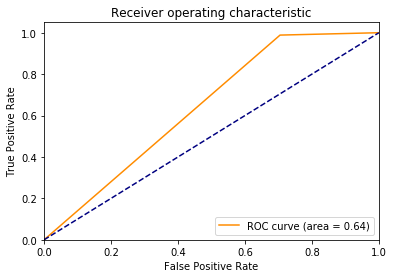

In [142]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


**CONFUSION MATRIX : TEST**


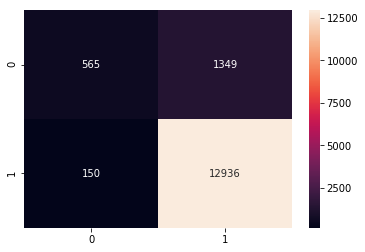

In [143]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')


**CONFUSION MATRIX : TRAIN**

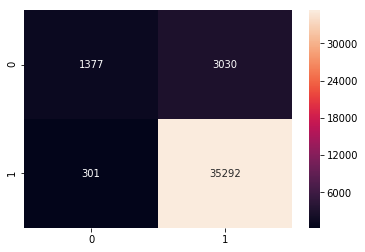

In [144]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [156]:
#importing the data for modelling 
tfw2v_train = pickle.load(open("Train_TFW2V.sav",'rb'))
tfw2v_test = pickle.load(open("Test_TFW2V.sav",'rb'))

#splitting the train into cv and Train 
X_train = tfw2v_train.iloc[:,0:51]
X_test = tfw2v_test.iloc[:,0:51]
X_cv = X_train[40000:55000]
X_test = X_train[55000:]
X_train = X_train[:40000].copy(deep=True)
y_train = X_train['Score'][:40000].copy(deep=True)
y_cv = X_cv['Score']
y_test = X_test['Score']
X_train = X_train.iloc[:,0:50].copy(deep=True)
X_test = X_test.iloc[:,0:50].copy(deep=True)
X_cv = X_cv.iloc[:,0:50].copy(deep=True)

In [159]:
#defining the metrics and range of C (hyperparameter)
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}
c = [0.0001,0.001,0.01,0.1,1,10,100,1000]
# running the loop for  single cross -validation 
for i in c:
    print("Running for C : " + str(i) + "\n")
    svm = SVC(C=i,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
    svm.fit(X_train,y_train)
    pred = svm.predict(X_cv)
    tpred =svm.predict(X_train)
    train_error[i] = 100-((accuracy_score(y_true = y_train,y_pred=tpred))*100)
    test_error[i] = 100-((accuracy_score(y_true = y_cv,y_pred=pred))*100)
    recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
    precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
    auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Running for C : 0.0001

[LibSVM]Running for C : 0.001

[LibSVM]Running for C : 0.01

[LibSVM]Running for C : 0.1

[LibSVM]Running for C : 1

[LibSVM]Running for C : 10

[LibSVM]Running for C : 100

[LibSVM]Running for C : 1000

[LibSVM]

**AUC-SCORE**

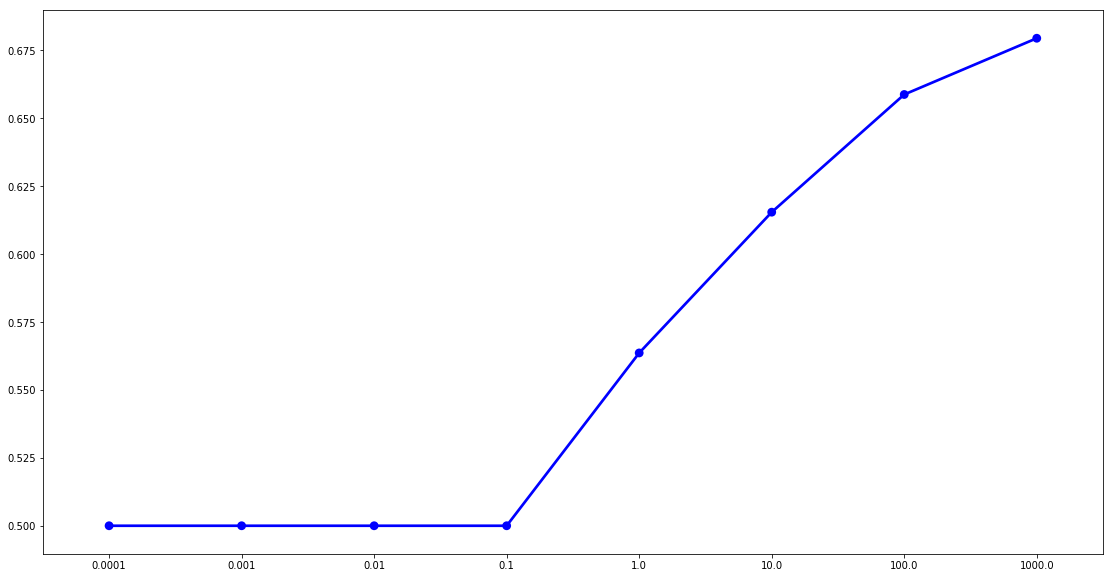

In [160]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

**RECALL : REVIEWS**

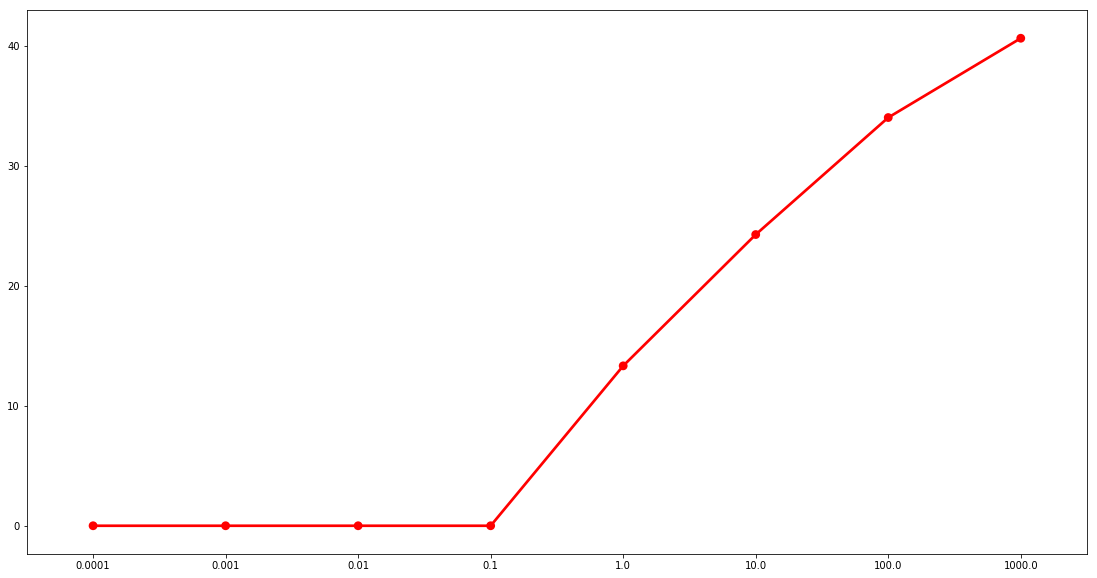

In [161]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')

**PRECISION: NEGATIVE REVIEWS**

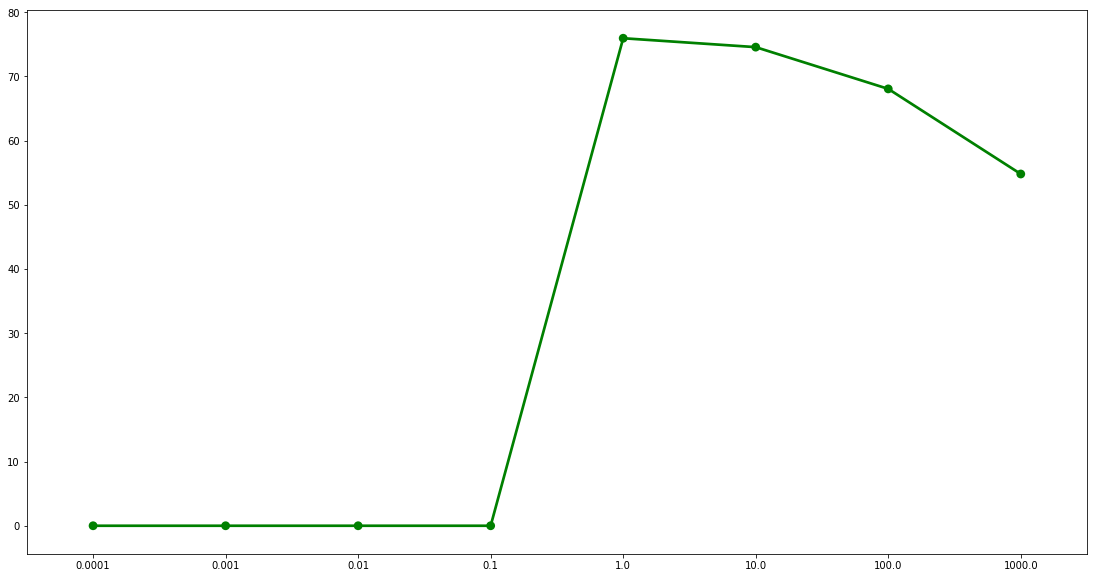

In [162]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')

**TRAIN AND TEST ERROR**

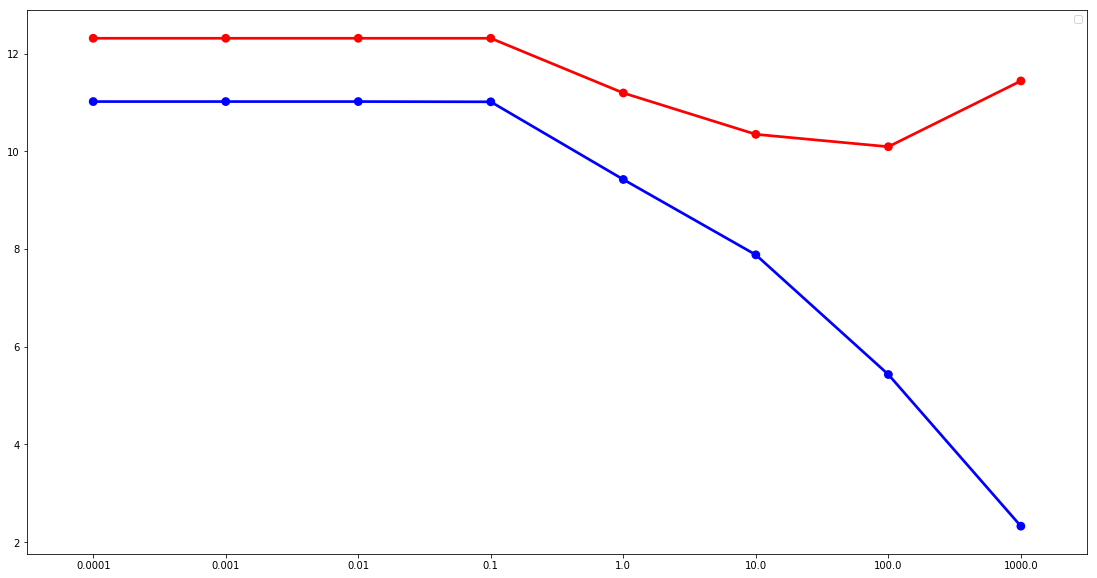

In [166]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),list(train_error.values()),color = 'blue')
sns.pointplot(list(test_error.keys()),list(test_error.values()),color = 'red')
plt.legend(('blue','red'),('Test_error','Train_error'))

**DIFFERENCE** 

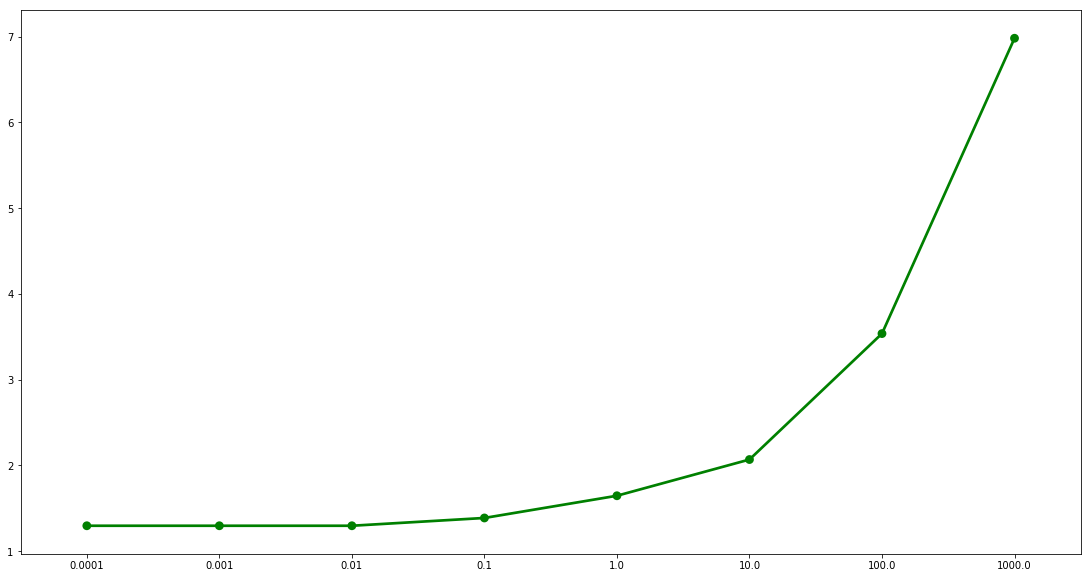

In [167]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),difference,color = 'green')

**C=1.0**

In [169]:
svm = SVC(C=10.0,kernel='rbf',cache_size=1000,verbose=True,max_iter = -1)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
tpred = svm.predict(X_train)

[LibSVM]

In [170]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42      1914
           1       0.90      0.99      0.94     13086

   micro avg       0.90      0.90      0.90     15000
   macro avg       0.84      0.64      0.68     15000
weighted avg       0.89      0.90      0.88     15000



In [171]:
print("TRAIN ERROR : " + str(100-(accuracy_score(y_true = y_train,y_pred=tpred))*100))
print("TEST ERROR : " + str(100-(accuracy_score(y_true = y_test,y_pred=pred))*100))

TRAIN ERROR : 7.8799999999999955
TEST ERROR : 10.200000000000003


<Br>
    
**ROC-AUC CURVE**

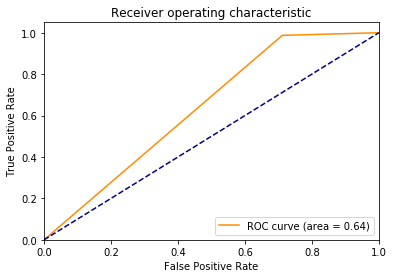

In [174]:
fpr, tpr, thresholds = roc_curve(y_test,pred)
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRIX : TEST**

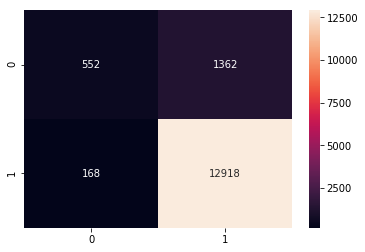

In [175]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

**CONFUSION MATRIX : TRAIN**

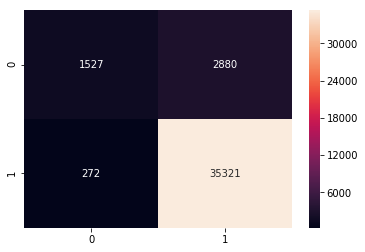

In [176]:
sns.heatmap(confusion_matrix(y_true = y_train,y_pred=tpred),annot= True,fmt='d')

# [6] Conclusions

<BR>
    
**SUMMARY**

<BR>

|FEATURIZATION|KERNEL|C| AUC CV |ACCURACY|TRAIN ERROR | TEST ERROR | DIFFERENCE|
|------|------|-----|-----|----|----|----|----|
|BOW |LINEAR|0.1|66|92.2|4.4|7.8|3.4|
|TFIDF| LINEAR|1.0|76|92.5|4.7|7.5|3.1|
|AVG WORD2VEC| LINEAR|0.1|63.8|89.72|9.28|10.82|1.54|
|TFIDF WORD2VEC| LINEAR|1.0|55|82.55|16.833|17.45|0.61|
|BOW |RBF|10.0|68|90.8|7.1|9.2|2.1|
|TFIDF|RBF|1000|70|91.39|7.04|8.61|1.57|
|AVG WORD2VEC| RBF|1.0|63|90|8.33|9.99|1.66|
|TFIDF WORD2VEC|RBF|1.0|62|89.8|7.87|10.20|2.33|

**Observations**

1. For Word2Vec Representations Linear SVMS do not perform well.
2. When RBF Kernel is applied to those representations the recall and precision along with AUC for negative reviews tend to increase.